#### Imports & Downloads

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
import vectorize_functions

from sklearn.metrics import mean_squared_error
import time
import optuna

from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances
from typing import Tuple
from sklearn.metrics import log_loss
from optuna.samplers import TPESampler

### Einladen der vektorisierten Daten - TFIDF

In [2]:
X_train, X_test, y_train, y_test = vectorize_functions.vectorize_w2v()

In [3]:
positive = np.count_nonzero(y_train == 1)
negative = np.count_nonzero(y_train == 0)
print("Train")
print("- Positive:", positive)
print("- Negative:", negative)
print("- Verhältnis:", negative / positive)

positive = np.count_nonzero(y_test == 1)
negative = np.count_nonzero(y_test == 0)
print("Test")
print("- Positive:", positive)
print("- Negative:", negative)
print("- Verhältnis:", negative / positive)

Train
- Positive: 1270
- Negative: 18084
- Verhältnis: 14.239370078740157
Test
- Positive: 541
- Negative: 7754
- Verhältnis: 14.33271719038817


In [4]:
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (19354, 100)
y_train shape (19354,)
X_test shape (8295, 100)
y_test shape (8295,)


### 2. Ensemble Models

In [5]:
evaluation = pd.DataFrame(
    columns=["model", "variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc", "test_prec",
             "test_rec", "test_f1"])

In [6]:
def add_to_eval_df(model, model_name, variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, variant, train_acc, train_precision, train_recall, train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [7]:
def evaluate_model(model, x_test, y_test, sampling_method):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'{sampling_method} model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

    probs = model.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#### 2.1 Bagging

##### 2.1.1 RandomForest

###### RandomForest no tuning

In [8]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

none model accuracy for classification is = 93.43%
------------------------------------------------
Confusion Matrix:
      0  1
0  7749  5
1   540  1
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      7754
           1       0.17      0.00      0.00       541

    accuracy                           0.93      8295
   macro avg       0.55      0.50      0.48      8295
weighted avg       0.88      0.93      0.90      8295



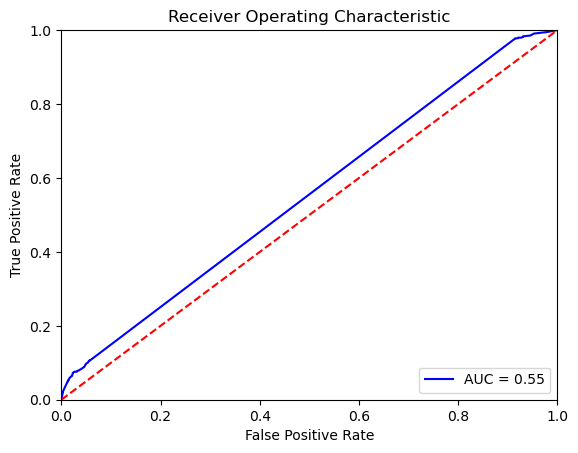

In [9]:
evaluate_model(rf, X_test, y_test, "none")
add_to_eval_df(rf, "RandomForestClassifier", "clean", X_train, y_train, X_test, y_test)

In [10]:
cv = cross_val_score(rf, X_train, y_train, cv=10, scoring='f1', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.000) total time=  14.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.5s remaining:    0.0s


[CV] END ................................ score: (test=0.000) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.7s remaining:    0.0s


[CV] END ................................ score: (test=0.000) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.9s remaining:    0.0s


[CV] END ................................ score: (test=0.000) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.7s remaining:    0.0s


[CV] END ................................ score: (test=0.016) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.5s remaining:    0.0s


[CV] END ................................ score: (test=0.000) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   20.2s remaining:    0.0s


[CV] END ................................ score: (test=0.016) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.0s remaining:    0.0s


[CV] END ................................ score: (test=0.000) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   21.7s remaining:    0.0s


[CV] END ................................ score: (test=0.000) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   22.4s remaining:    0.0s


[CV] END ................................ score: (test=0.000) total time=   0.7s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.2s finished


In [11]:
np.mean(cv)

0.003112887596899225

###### RandomForest tuning (GridSearchCV)

In [12]:
# todo

###### RandomForest tuning (RandomizedSearchCV)

In [13]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [9, 11, 13],
}

In [14]:
random_search = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1),
                                   param_grid,
                                   scoring='f1',
                                   verbose=10)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=6, max_features=log2, max_leaf_nodes=11, n_estimators=150
[CV 1/5; 1/10] END max_depth=6, max_features=log2, max_leaf_nodes=11, n_estimators=150;, score=0.000 total time=   0.5s
[CV 2/5; 1/10] START max_depth=6, max_features=log2, max_leaf_nodes=11, n_estimators=150
[CV 2/5; 1/10] END max_depth=6, max_features=log2, max_leaf_nodes=11, n_estimators=150;, score=0.000 total time=   0.4s
[CV 3/5; 1/10] START max_depth=6, max_features=log2, max_leaf_nodes=11, n_estimators=150
[CV 3/5; 1/10] END max_depth=6, max_features=log2, max_leaf_nodes=11, n_estimators=150;, score=0.000 total time=   0.5s
[CV 4/5; 1/10] START max_depth=6, max_features=log2, max_leaf_nodes=11, n_estimators=150
[CV 4/5; 1/10] END max_depth=6, max_features=log2, max_leaf_nodes=11, n_estimators=150;, score=0.000 total time=   0.5s
[CV 5/5; 1/10] START max_depth=6, max_features=log2, max_leaf_nodes=11, n_estimators=150
[CV 5/5; 1/10]

RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [3, 6, 9],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='f1', verbose=10)

In [15]:
print(random_search.best_estimator_)

RandomForestClassifier(max_depth=6, max_features='log2', max_leaf_nodes=11,
                       n_estimators=150, n_jobs=-1)


In [16]:
rf_tuned = RandomForestClassifier(**random_search.best_params_)
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features='log2', max_leaf_nodes=11,
                       n_estimators=150)

none model accuracy for classification is = 93.48%
------------------------------------------------
Confusion Matrix:
      0  1
0  7754  0
1   541  0
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      7754
           1       0.00      0.00      0.00       541

    accuracy                           0.93      8295
   macro avg       0.47      0.50      0.48      8295
weighted avg       0.87      0.93      0.90      8295



C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


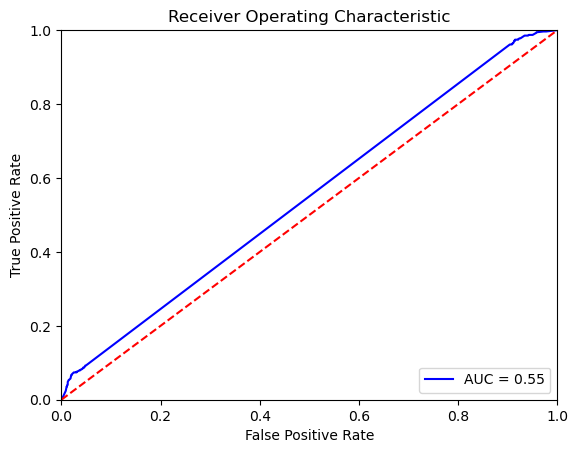

C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
evaluate_model(rf_tuned, X_test, y_test, "none")
add_to_eval_df(rf_tuned, "RandomForestClassifier-tuned-rand", "clean", X_train, y_train, X_test, y_test)

###### RandomForest tuning (optuna)
https://gist.github.com/shamilnabiyev/c1b6e23444a949bc45243eab445a3806

In [18]:
# todo: überarbeiten, callback hinzufügen wie bei xgboost optuna tuning, mehr trials

In [19]:
def objective(trial):
    # Number of trees in random forest
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=500, step=100)

    # Number of features to consider at every split
    max_features = trial.suggest_categorical(name="max_features", choices=['auto', 'sqrt'])

    # Maximum number of levels in tree
    max_depth = trial.suggest_int(name="max_depth", low=10, high=110, step=20)

    # Minimum number of samples required to split a node
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10, step=2)

    # Minimum number of samples required at each leaf node
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)

    params = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf
    }
    model = RandomForestClassifier(random_state=42, **params)

    cv_score = cross_val_score(model, X_train, y_train, n_jobs=4, cv=5, scoring='f1')
    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy

# study = optuna.create_study()
# study.optimize(objective, n_trials=5)

best_model = RandomForestClassifier(random_state=42, **study.best_params)
best_model.fit(X_train, y_train)

evaluate_model(best_model, X_test, y_test, "none")
add_to_eval_df(best_model, "RandomForestClassifier-tuned-optuna", "clean", X_train, y_train, X_test, y_test)

##### 2.1.2 BalancedRandomForest untuned

###### BalancedRandomForest no tuning

In [20]:
brf = BalancedRandomForestClassifier(n_jobs=-1)
brf.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

BalancedRandomForestClassifier(n_jobs=-1)

none model accuracy for classification is = 88.05%
------------------------------------------------
Confusion Matrix:
      0    1
0  7243  511
1   480   61
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      7754
           1       0.11      0.11      0.11       541

    accuracy                           0.88      8295
   macro avg       0.52      0.52      0.52      8295
weighted avg       0.88      0.88      0.88      8295



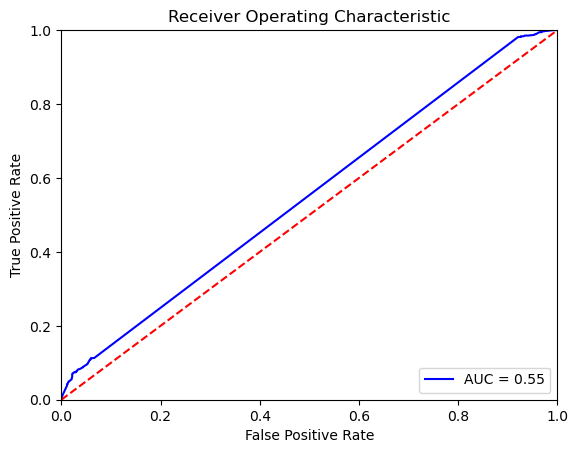

In [21]:
evaluate_model(brf, X_test, y_test, "none")
add_to_eval_df(brf, "BalancedRandomForestClassifier", "clean", X_train, y_train, X_test, y_test)

In [22]:
cv = cross_val_score(brf, X_train, y_train, cv=10, scoring='f1', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] START .....................................................................
[CV] END ................................ score: (test=0.126) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.150) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.092) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.1s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.091) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.1s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.189) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.0s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.090) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.3s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.113) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   11.5s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.107) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   13.0s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.097) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   15.3s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.191) total time=   1.3s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.7s finished


In [23]:
np.mean(cv)

0.12457478211114412

###### BalancedRandomForest tuning (RandomizedSearchCV)

In [24]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [9, 11, 13],
}

In [25]:
random_search = RandomizedSearchCV(BalancedRandomForestClassifier(n_jobs=-1),
                                   param_grid,
                                   scoring='f1',
                                   verbose=0)
random_search.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: 

RandomizedSearchCV(estimator=BalancedRandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [3, 6, 9],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='f1')

In [26]:
brf_tuned = BalancedRandomForestClassifier(**random_search.best_params_, verbose=0)
brf_tuned.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklear

BalancedRandomForestClassifier(max_depth=9, max_leaf_nodes=11, n_estimators=250)

none model accuracy for classification is = 88.35%
------------------------------------------------
Confusion Matrix:
      0    1
0  7270  484
1   482   59
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7754
           1       0.11      0.11      0.11       541

    accuracy                           0.88      8295
   macro avg       0.52      0.52      0.52      8295
weighted avg       0.88      0.88      0.88      8295



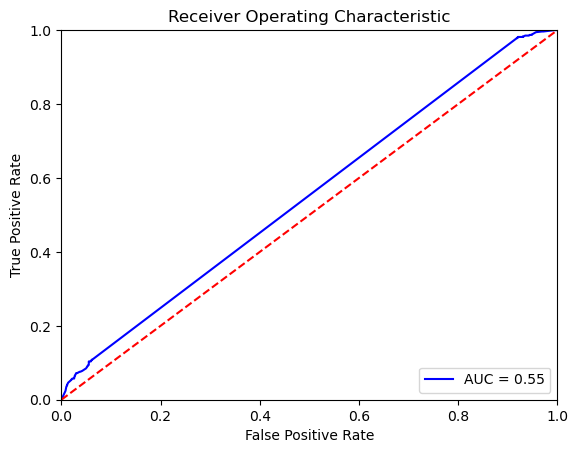

In [27]:
evaluate_model(brf_tuned, X_test, y_test, "none")
add_to_eval_df(brf, "BalancedRandomForestClassifier-tuned", "clean", X_train, y_train, X_test, y_test)

#### 2.2 Boosting

##### 2.2.1 XGBClassifier

In [28]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 93.41%
------------------------------------------------
Confusion Matrix:
      0  1
0  7747  7
1   540  1
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      7754
           1       0.12      0.00      0.00       541

    accuracy                           0.93      8295
   macro avg       0.53      0.50      0.48      8295
weighted avg       0.88      0.93      0.90      8295



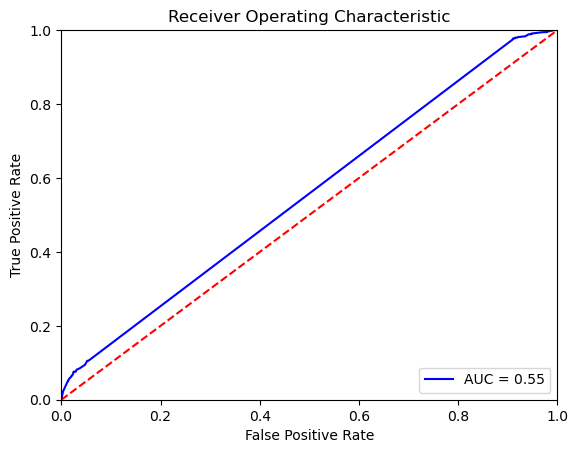

In [29]:
evaluate_model(xgb, X_test, y_test, "none")
add_to_eval_df(xgb, "XGBClassifier", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (GridSearchCV)
https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Tuning mit GridSearchCV dauert bei großer param-Liste sehr lange, daher einzelne Schritte mit jeweils nur 1 bis max. 2 params


In [30]:
param_test = {
    'learning_rate': [0.1, 0.01, 0.001],
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.32039688186494825, {'learning_rate': 0.1})

none model accuracy for classification is = 93.41%
------------------------------------------------
Confusion Matrix:
      0  1
0  7748  6
1   541  0
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      7754
           1       0.00      0.00      0.00       541

    accuracy                           0.93      8295
   macro avg       0.47      0.50      0.48      8295
weighted avg       0.87      0.93      0.90      8295



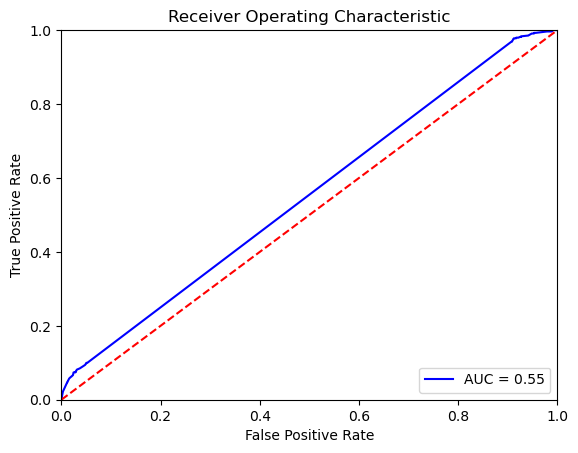

In [31]:
xgb_test = XGBClassifier(learning_rate=0.1)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [32]:
param_test = {
    'n_estimators': range(100, 250, 50),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.37817637241282653, {'n_estimators': 200})

none model accuracy for classification is = 93.45%
------------------------------------------------
Confusion Matrix:
      0  1
0  7747  7
1   536  5
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7754
           1       0.42      0.01      0.02       541

    accuracy                           0.93      8295
   macro avg       0.68      0.50      0.49      8295
weighted avg       0.90      0.93      0.90      8295



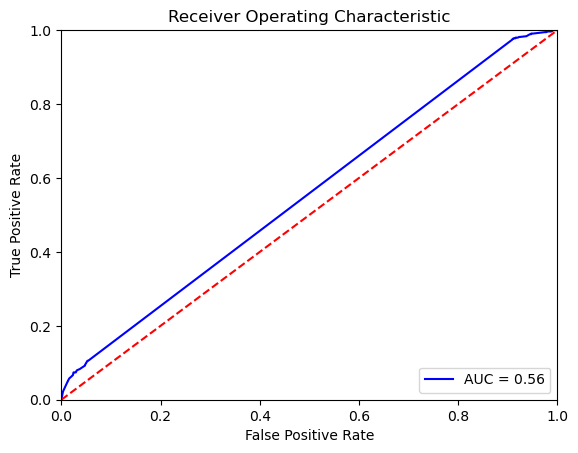

In [33]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [34]:
param_test = {
    'max_depth': range(5, 13, 2),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4298347587940351, {'max_depth': 11})

none model accuracy for classification is = 93.39%
------------------------------------------------
Confusion Matrix:
      0  1
0  7746  8
1   540  1
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      7754
           1       0.11      0.00      0.00       541

    accuracy                           0.93      8295
   macro avg       0.52      0.50      0.48      8295
weighted avg       0.88      0.93      0.90      8295



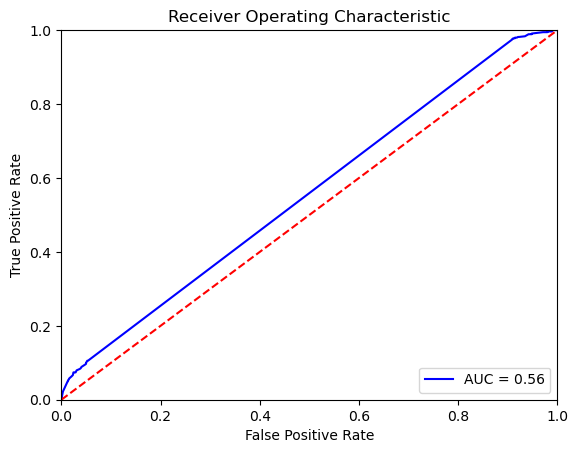

In [35]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [36]:
param_test = {
    'subsample': [0.5, 0.7, 1]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'subsample': 0.7})

none model accuracy for classification is = 93.43%
------------------------------------------------
Confusion Matrix:
      0  1
0  7749  5
1   540  1
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      7754
           1       0.17      0.00      0.00       541

    accuracy                           0.93      8295
   macro avg       0.55      0.50      0.48      8295
weighted avg       0.88      0.93      0.90      8295



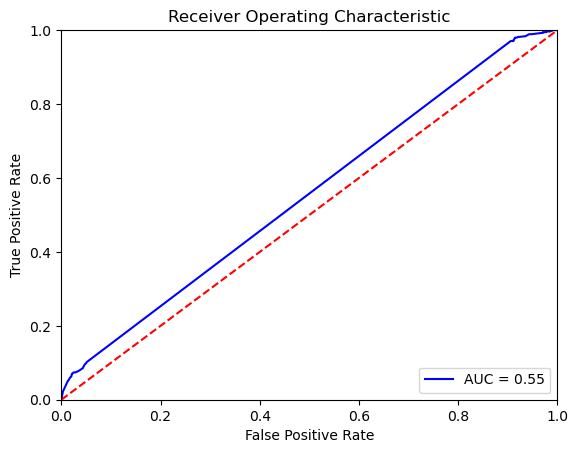

In [37]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [38]:
param_test = {
    'min_child_weight': range(1, 6, 2),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'min_child_weight': 1}) <== kein Einfluss auf Modellperformance

In [39]:
param_test = {
    'gamma': [i / 10.0 for i in range(0, 5)],
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'gamma': 0.0}) <== kein Einfluss auf Modellperformance

In [40]:
param_test = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

gsearch.fit(X_train, y_train)
gsearch.best_score_, gsearch.best_params_

# (0.44114103318625436, {'reg_alpha': 0.01})

Fitting 5 folds for each of 5 candidates, totalling 25 fits


(0.003131127450980392, {'reg_alpha': 1})

In [41]:
param_test = {
    'reg_alpha': [0.005, 0.01, 0.015, 0.02, 0.025]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

gsearch.fit(X_train, y_train)
gsearch.best_score_, gsearch.best_params_

# # (0.44114103318625436, {'reg_alpha': 0.01})

Fitting 5 folds for each of 5 candidates, totalling 25 fits


(0.003125, {'reg_alpha': 0.02})

In [42]:
xgb_tuned_grid = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7, reg_alpha=0.01)
xgb_tuned_grid.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 93.48%
------------------------------------------------
Confusion Matrix:
      0  1
0  7749  5
1   536  5
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7754
           1       0.50      0.01      0.02       541

    accuracy                           0.93      8295
   macro avg       0.72      0.50      0.49      8295
weighted avg       0.91      0.93      0.90      8295



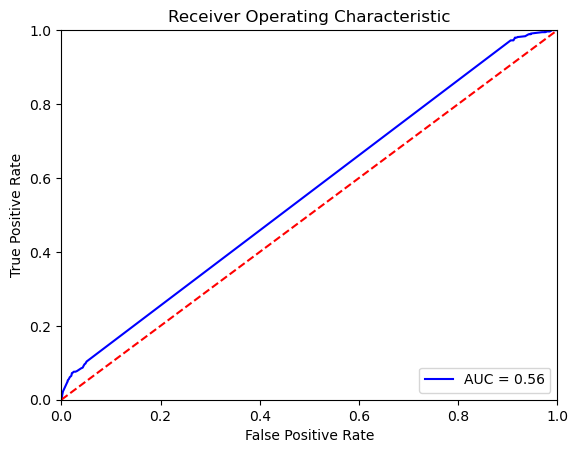

In [43]:
evaluate_model(xgb_tuned_grid, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_grid, "XGBClassifier-tuned-grid", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (RandomizedSearchCV)
Vergleich Modellperformance zwischen GridSearchCV <-> RandomizedSearchCV

In [44]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': range(100, 250, 50),
    'max_depth': range(5, 13, 2),
    'subsample': [0.5, 0.7, 1],
    'min_child_weight': range(1, 6, 2),
    'gamma': [i / 10.0 for i in range(0, 5)],
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
}

In [45]:
rsearch = RandomizedSearchCV(XGBClassifier(n_jobs=-1),
                             param_grid,
                             scoring='f1',
                             verbose=1,
                             cv=5,
                             )

In [46]:
rsearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': range(5, 13, 2),
                                        'min_child_weight': range(1, 6, 2),
                                        'n_estimators': range(100, 250, 50),
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],
                                        'subsample': [0.5, 0.7, 1]},
                   scoring='f1', verbose=1)

In [47]:
rsearch.best_score_, rsearch.best_params_

(0.003131127450980392,
 {'subsample': 0.5,
  'reg_alpha': 0.01,
  'n_estimators': 150,
  'min_child_weight': 3,
  'max_depth': 7,
  'learning_rate': 0.1,
  'gamma': 0.4})

In [48]:
xgb_tuned_rand = XGBClassifier(**rsearch.best_params_, n_jobs=-1)
xgb_tuned_rand.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 93.45%
------------------------------------------------
Confusion Matrix:
      0  1
0  7752  2
1   541  0
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      7754
           1       0.00      0.00      0.00       541

    accuracy                           0.93      8295
   macro avg       0.47      0.50      0.48      8295
weighted avg       0.87      0.93      0.90      8295



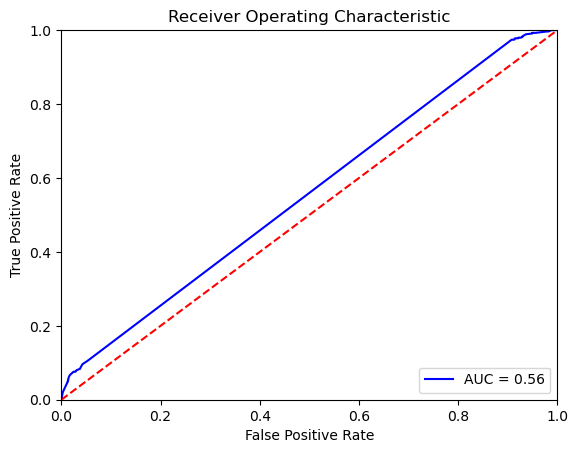

In [49]:
evaluate_model(xgb_tuned_rand, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_rand, "XGBClassifier-tuned-rand", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (optuna)
https://randomrealizations.com/posts/xgboost-parameter-tuning-with-optuna/

https://www.kaggle.com/code/rzatemizel/optuna-xgboostcv-integration-with-pruning#Intro

def balancedlogloss(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    ''' balanced log loss metric.'''
    y = dtrain.get_label()
    target_mean = y.mean()
    w0 = 1 / (1 - target_mean)
    w1 = 1 / target_mean
    sample_weight = [w0 if y == 0 else w1 for y in y]
    loss = log_loss(y, predt, eps=1e-15, sample_weight=sample_weight)

    return 'balancedlogloss', loss

def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)

    param = {

        "verbosity": 0,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.8),
        'scale_pos_weight': 509 / 108,
        'random_state': 42,
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 16)
        param["eta"] = trial.suggest_float("eta", 1e-3, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-balancedlogloss")
    history = xgb.cv(param,
                     dtrain,
                     stratified=True,
                     nfold=5,
                     num_boost_round=10000,
                     early_stopping_rounds=50,
                     custom_metric=balancedlogloss,
                     seed=42,
                     callbacks=[pruning_callback])

    mean_balancedlogloss = history["test-balancedlogloss-mean"].values[-1]
    trial.set_user_attr("n_estimators", len(history))
    return mean_balancedlogloss


sampler = TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
study = optuna.create_study(sampler=sampler, pruner=pruner, direction="minimize")
study.optimize(objective, n_trials=5)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
print("  Number of estimators: {}".format(trial.user_attrs["n_estimators"]))

plot_optimization_history(study)
plot_param_importances(study)

xgb_tuned_optuna = XGBClassifier(**study.best_trial.params)
evaluate_model(xgb_tuned_optuna, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_optuna, "XGBClassifier-tuned-optuna", "clean", X_train, y_train, X_test, y_test)

##### 2.2.1 CatBoostClassifier

In [52]:
cat = CatBoostClassifier(iterations=100,
                         depth=5,
                         learning_rate=0.1,
                         loss_function='Logloss',
                         verbose=True)
cat.fit(X_train, y_train)

0:	learn: 0.5846403	total: 317ms	remaining: 31.4s
1:	learn: 0.5023767	total: 414ms	remaining: 20.3s
2:	learn: 0.4400108	total: 494ms	remaining: 16s
3:	learn: 0.3921756	total: 609ms	remaining: 14.6s
4:	learn: 0.3566545	total: 705ms	remaining: 13.4s
5:	learn: 0.3296590	total: 796ms	remaining: 12.5s
6:	learn: 0.3089923	total: 911ms	remaining: 12.1s
7:	learn: 0.2932431	total: 984ms	remaining: 11.3s
8:	learn: 0.2809182	total: 1.1s	remaining: 11.1s
9:	learn: 0.2714233	total: 1.17s	remaining: 10.5s
10:	learn: 0.2641696	total: 1.26s	remaining: 10.2s
11:	learn: 0.2582199	total: 1.34s	remaining: 9.85s
12:	learn: 0.2538288	total: 1.45s	remaining: 9.71s
13:	learn: 0.2503438	total: 1.53s	remaining: 9.39s
14:	learn: 0.2475288	total: 1.63s	remaining: 9.23s
15:	learn: 0.2453657	total: 1.72s	remaining: 9.04s
16:	learn: 0.2434743	total: 1.8s	remaining: 8.81s
17:	learn: 0.2420205	total: 1.91s	remaining: 8.72s
18:	learn: 0.2409460	total: 1.99s	remaining: 8.47s
19:	learn: 0.2399302	total: 2.09s	remaining: 

none model accuracy for classification is = 93.43%
------------------------------------------------
Confusion Matrix:
      0  1
0  7750  4
1   541  0
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      7754
           1       0.00      0.00      0.00       541

    accuracy                           0.93      8295
   macro avg       0.47      0.50      0.48      8295
weighted avg       0.87      0.93      0.90      8295



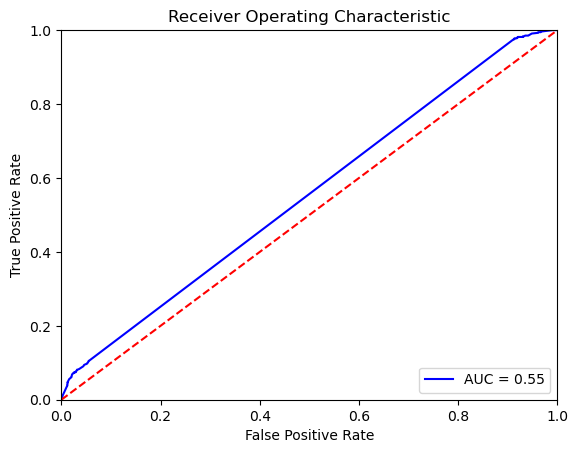

In [53]:
evaluate_model(cat, X_test, y_test, "none")
add_to_eval_df(cat, "CatBoostClassifier", "clean", X_train, y_train, X_test, y_test)

##### 2.2.1 LGBMClassifier

In [54]:
light = LGBMClassifier()
light.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1270, number of negative: 18084
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.627037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19513
[LightGBM] [Info] Number of data points in the train set: 19354, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065620 -> initscore=-2.656011
[LightGBM] [Info] Start training from score -2.656011


LGBMClassifier()

none model accuracy for classification is = 93.41%
------------------------------------------------
Confusion Matrix:
      0  1
0  7747  7
1   540  1
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      7754
           1       0.12      0.00      0.00       541

    accuracy                           0.93      8295
   macro avg       0.53      0.50      0.48      8295
weighted avg       0.88      0.93      0.90      8295



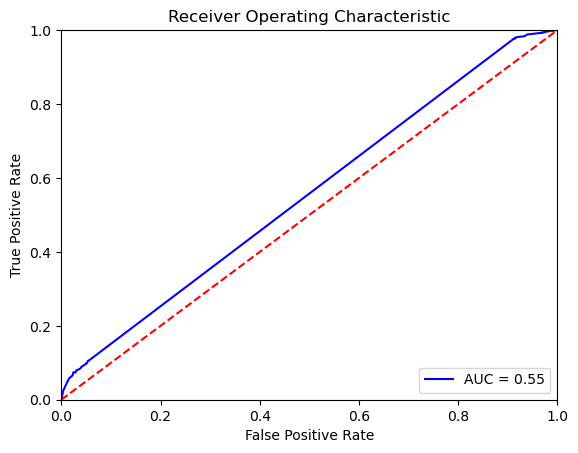

In [55]:
evaluate_model(light, X_test, y_test, "none")
add_to_eval_df(light, "LGBMClassifier", "clean", X_train, y_train, X_test, y_test)

#### 2.3 Stacking

##### 2.3.1 Stacking: RandomForest + LinearSVC

In [56]:
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', LinearSVC(random_state=42))
]
stack = StackingClassifier(estimators=base_models, n_jobs=-1)

In [57]:
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svc', LinearSVC(random_state=42))],
                   n_jobs=-1)

none model accuracy for classification is = 93.48%
------------------------------------------------
Confusion Matrix:
      0  1
0  7754  0
1   541  0
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      7754
           1       0.00      0.00      0.00       541

    accuracy                           0.93      8295
   macro avg       0.47      0.50      0.48      8295
weighted avg       0.87      0.93      0.90      8295



C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


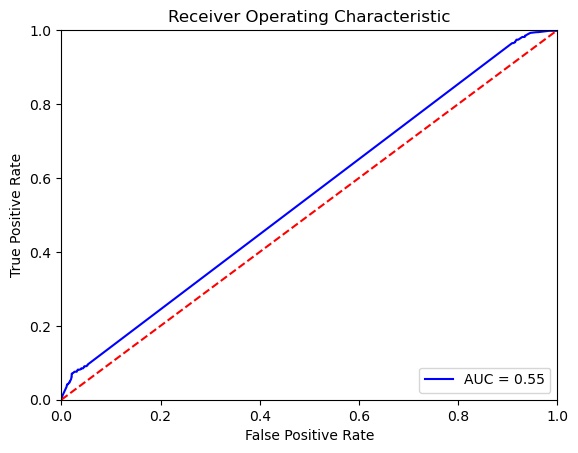

C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
evaluate_model(stack, X_test, y_test, "none")
add_to_eval_df(stack, "StackingClassifier", "clean", X_train, y_train, X_test, y_test)

Vergleich: SVC

In [59]:
svc = LinearSVC()
svc.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [60]:
evaluate_model(svc, X_test, y_test, "none")
add_to_eval_df(svc, "LinearSVC", "clean", X_train, y_train, X_test, y_test)

none model accuracy for classification is = 93.48%
------------------------------------------------
Confusion Matrix:
      0  1
0  7754  0
1   541  0
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      7754
           1       0.00      0.00      0.00       541

    accuracy                           0.93      8295
   macro avg       0.47      0.50      0.48      8295
weighted avg       0.87      0.93      0.90      8295



C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

#### Model comparision

In [61]:
evaluation.drop_duplicates(inplace=True)

In [62]:
evaluation.sort_values(by=["test_prec"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
5,XGBClassifier-tuned-grid,clean,0.935311,0.950000,0.014961,0.029457,0.934780,0.500000,0.009242,0.018149
0,RandomForestClassifier,clean,0.935311,1.000000,0.014173,0.027950,0.934298,0.166667,0.001848,0.003656
4,XGBClassifier,clean,0.935311,1.000000,0.014173,0.027950,0.934057,0.125000,0.001848,0.003643
8,LGBMClassifier,clean,0.935311,1.000000,0.014173,0.027950,0.934057,0.125000,0.001848,0.003643
2,BalancedRandomForestClassifier,clean,0.882505,0.136758,0.148819,0.142534,0.880530,0.106643,0.112754,0.109614
3,BalancedRandomForestClassifier-tuned,clean,0.882505,0.136758,0.148819,0.142534,0.880530,0.106643,0.112754,0.109614
1,RandomForestClassifier-tuned-rand,clean,0.934432,1.000000,0.000787,0.001574,0.934780,0.000000,0.000000,0.000000
6,XGBClassifier-tuned-rand,clean,0.935156,1.000000,0.011811,0.023346,0.934539,0.000000,0.000000,0.000000
7,CatBoostClassifier,clean,0.935001,1.000000,0.009449,0.018721,0.934298,0.000000,0.000000,0.000000
9,StackingClassifier,clean,0.934484,1.000000,0.001575,0.003145,0.934780,0.000000,0.000000,0.000000


In [63]:
evaluation.sort_values(by=["test_rec"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
2,BalancedRandomForestClassifier,clean,0.882505,0.136758,0.148819,0.142534,0.880530,0.106643,0.112754,0.109614
3,BalancedRandomForestClassifier-tuned,clean,0.882505,0.136758,0.148819,0.142534,0.880530,0.106643,0.112754,0.109614
5,XGBClassifier-tuned-grid,clean,0.935311,0.950000,0.014961,0.029457,0.934780,0.500000,0.009242,0.018149
0,RandomForestClassifier,clean,0.935311,1.000000,0.014173,0.027950,0.934298,0.166667,0.001848,0.003656
4,XGBClassifier,clean,0.935311,1.000000,0.014173,0.027950,0.934057,0.125000,0.001848,0.003643
8,LGBMClassifier,clean,0.935311,1.000000,0.014173,0.027950,0.934057,0.125000,0.001848,0.003643
1,RandomForestClassifier-tuned-rand,clean,0.934432,1.000000,0.000787,0.001574,0.934780,0.000000,0.000000,0.000000
6,XGBClassifier-tuned-rand,clean,0.935156,1.000000,0.011811,0.023346,0.934539,0.000000,0.000000,0.000000
7,CatBoostClassifier,clean,0.935001,1.000000,0.009449,0.018721,0.934298,0.000000,0.000000,0.000000
9,StackingClassifier,clean,0.934484,1.000000,0.001575,0.003145,0.934780,0.000000,0.000000,0.000000


In [64]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
2,BalancedRandomForestClassifier,clean,0.882505,0.136758,0.148819,0.142534,0.880530,0.106643,0.112754,0.109614
3,BalancedRandomForestClassifier-tuned,clean,0.882505,0.136758,0.148819,0.142534,0.880530,0.106643,0.112754,0.109614
5,XGBClassifier-tuned-grid,clean,0.935311,0.950000,0.014961,0.029457,0.934780,0.500000,0.009242,0.018149
0,RandomForestClassifier,clean,0.935311,1.000000,0.014173,0.027950,0.934298,0.166667,0.001848,0.003656
4,XGBClassifier,clean,0.935311,1.000000,0.014173,0.027950,0.934057,0.125000,0.001848,0.003643
8,LGBMClassifier,clean,0.935311,1.000000,0.014173,0.027950,0.934057,0.125000,0.001848,0.003643
1,RandomForestClassifier-tuned-rand,clean,0.934432,1.000000,0.000787,0.001574,0.934780,0.000000,0.000000,0.000000
6,XGBClassifier-tuned-rand,clean,0.935156,1.000000,0.011811,0.023346,0.934539,0.000000,0.000000,0.000000
7,CatBoostClassifier,clean,0.935001,1.000000,0.009449,0.018721,0.934298,0.000000,0.000000,0.000000
9,StackingClassifier,clean,0.934484,1.000000,0.001575,0.003145,0.934780,0.000000,0.000000,0.000000


none model accuracy for classification is = 93.43%
------------------------------------------------
Confusion Matrix:
      0  1
0  7749  5
1   540  1
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      7754
           1       0.17      0.00      0.00       541

    accuracy                           0.93      8295
   macro avg       0.55      0.50      0.48      8295
weighted avg       0.88      0.93      0.90      8295



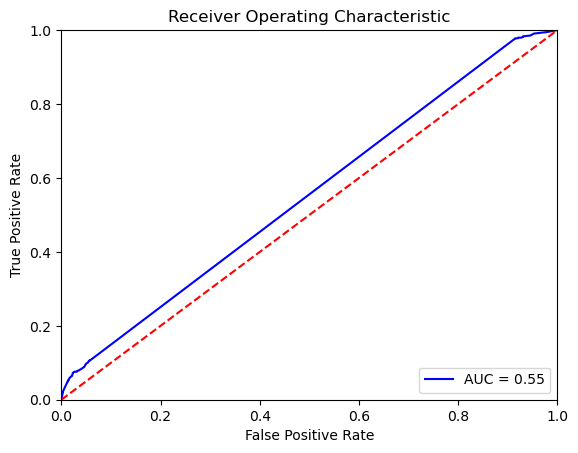

In [65]:
evaluate_model(rf, X_test, y_test, "none")

#### Auswertung

- Performance deutlich unter TF-IDF und BOW
- sehr wahrscheinlich Vektorisierungmethode fehlerhaft / falsche Parameter